In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np


def plot(y, x=None):
    if x == None:
        x = list(range(1, len(y) + 1))
    depth = [407, 878, 1441, 1760, 2363, 3007, 3186, 3378, 3478,
             3578, 3678, 3778, 3878, 3978, 4078]

    plt.plot(x, y)

    last = 0
    curSum = 0
    for d in depth[:-8]:
        if d != 1343:
            plt.axvline(d-1, c="black")

    plt.axvline(1342, c='r', ls="--")

In [28]:
%run src/gen-data.py

In [8]:
%run src/gen-trees.py

Node 0: Index -1 <= 0.0 == true (predict 4.8245699614163725E-4) has 506 children, depth 0.


In [9]:
import pickle

# pickle.dump(data, open("data.pkl", 'wb'))
# pickle.dump(trees, open("trees.pkl", 'wb'))
# pickle.dump(randomwalk, open("rw.pkl", 'wb'))

# Load data

In [1]:
import pickle

data = pickle.load(open("data.pkl", 'rb'))
trees = pickle.load(open("trees.pkl", 'rb'))
# randomwalk = pickle.load(open("rw.pkl", 'rb'))

In [7]:
# data[j] stores following variables:
#   (when it can early stop, empirical gamma when stopped, final empirical gamma, info when stopped, final info)
# where info is
#    (
#     number of examples scanned so far,
#     number of examples in this rule,
#     sum_(wi * yi) for h_j(x_i) != 0,
#     sum_(wi)      for h_j(x_i) != 0,
#     sum_(wi^2)    for h_j(x_i) != 0,
#     sum_(w)       for all x_i
#    )
data[0]

# trees[i] is a triplet for weak learner i: (prediction, parent-node-id, depth, (position, one_or_zero))
trees[0]

# randomwalk[i] is the accumulative path of \sum_(w_i*y_i)
#randomwalk[i][:3]

(0.00048245699614163725, -1, 0, (-1, False))

# Analysis

In [8]:
# 1. The number of examples
numExamples = [t[-1][1] for t in data]

# 2. ratio between the effective number of examples
#    and the actual number of examples on which the rule is non-zero
effectiveNum = []
for d in data:
    (_, _, _, wi, wi2, _) = d[-1]
    effectiveNum.append(wi * wi / wi2)
ratios = [a / b for a, b in zip(effectiveNum, numExamples)]

# 3. The empirical correlation at the end for all x
emprCorrAll = []
for d, tree in zip(data, trees):
    (_, _, s, _, _, sumw_all) = d[-1]
    hx = tree[0]
    emprCorrAll.append(hx * s / sumw_all)

# 4. The empirical correlation wrt the examples for which h_j(x) != 0
emprCorrNonzero = []
for d, tree in zip(data, trees):
    (_, _, s, sumw_nonzero, _, _) = d[-1]
    hx = tree[0]
    emprCorrNonzero.append(hx * s / sumw_nonzero)

# 5. The probability of the the set of examples for which h_j(x) != 0
pNonzero = []
for d in data:
    (_, _, _, sumw_nonzero, _, sumw_all) = d[-1]
    pNonzero.append(sumw_nonzero / sumw_all)

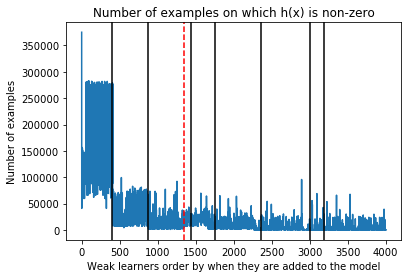

In [9]:
plot(numExamples)
plt.title("Number of examples on which h(x) is non-zero")
plt.ylabel("Number of examples")
plt.xlabel("Weak learners order by when they are added to the model")

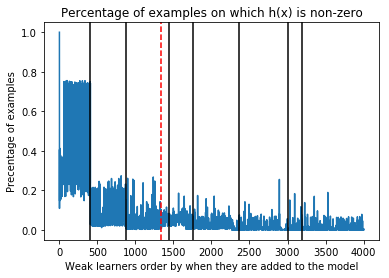

In [10]:
plot(pNonzero)
plt.title("Percentage of examples on which h(x) is non-zero")
plt.ylabel("Precentage of examples")
plt.xlabel("Weak learners order by when they are added to the model")

(0, 100000)

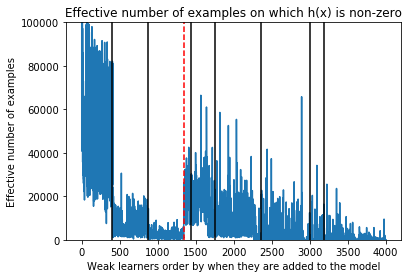

In [11]:
plot(effectiveNum)
plt.title("Effective number of examples on which h(x) is non-zero")
plt.ylabel("Effective number of examples")
plt.xlabel("Weak learners order by when they are added to the model")
plt.ylim(0, 100000)

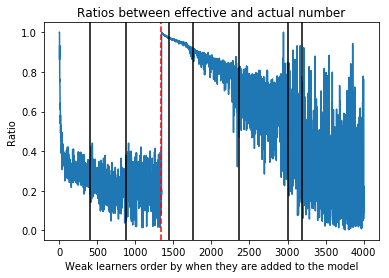

In [12]:
plot(ratios)
plt.title("Ratios between effective and actual number")
plt.ylabel("Ratio")
plt.xlabel("Weak learners order by when they are added to the model")

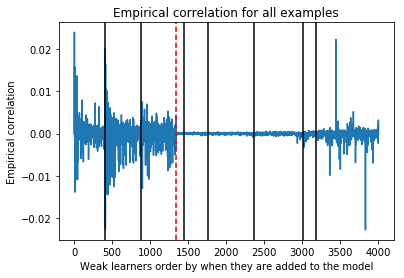

In [13]:
plot(emprCorrAll)
plt.title("Empirical correlation for all examples")
plt.ylabel("Empirical correlation")
plt.xlabel("Weak learners order by when they are added to the model")

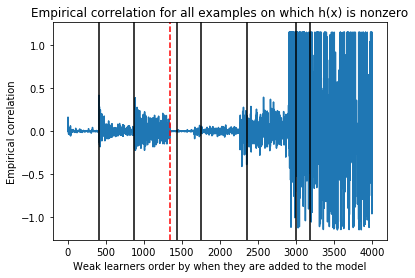

In [14]:
plot(emprCorrNonzero)
plt.title("Empirical correlation for all examples on which h(x) is nonzero")
plt.ylabel("Empirical correlation")
plt.xlabel("Weak learners order by when they are added to the model")

# Visualize the Tree

In [15]:
import pickle

trees = pickle.load(open("trees.pkl", 'rb'))

In [16]:
%run src/posmap.py

In [23]:
# %load src/pydot.py
"""
pydot example 1
@author: Federico Cáceres
@url: http://pythonhaven.wordpress.com/2009/12/09/generating_graphs_with_pydot
"""
import pydot
graph = pydot.Dot(graph_type='graph')
added = set([])

def addNode(idx):
    if idx in added:
        return
    added.add(idx)
    (pred, fa, depth, (dim, res)) = trees[idx]
    if dim < 0:
        node1 = pydot.Node(shape="box")
        node1.set_name(str(idx))
        node1.set_label("root")

        label2 = "%.2f" % pred
        if pred > 0:
            label2 = '+' + label2
        node2 = pydot.Node()
        node2.set_name("s" + str(idx))
        node2.set_label(label2)

        graph.add_node(node1)
        graph.add_node(node2)
        edge = pydot.Edge(node1, node2, dir="forward")
        edge.set_label("Y")
        graph.add_edge(edge)
        return

    (pos, base) = posMap[dim]
    if pos > 0:
        posval = '+%.2f' % pos
    else:
        posval = pos
    label1 = "Position " + str(posval) + " is " + base
    label2 = "%.2f" % pred
    if pred > 0:
        label2 = '+' + label2

    node1 = pydot.Node(shape="box")
    node1.set_name(str(idx))
    node1.set_label(label1)

    node2 = pydot.Node()
    node2.set_name("s" + str(idx))
    node2.set_label(label2)

    graph.add_node(node1)
    graph.add_node(node2)
    edge = pydot.Edge(node1, node2, dir="forward")
    if t[-1][1]:
        edge.set_label("Y")
    else:
        edge.set_label("N")
    graph.add_edge(edge)


ImportError: No module named pydot

In [21]:
#del graph

graph = pydot.Dot(graph_type='graph')
added = set([])

NameError: name 'pydot' is not defined

In [19]:
for idx, t in enumerate(trees[:10]):
    addNode(idx)
    if t[1] >= 0:
        addNode(t[1])
        edge = pydot.Edge("s" + str(t[1]), str(idx), dir="forward", style="dashed")
        # print dir(edge)
        # break
        graph.add_edge(edge)

graph.write_png('tree.png')


NameError: name 'addNode' is not defined

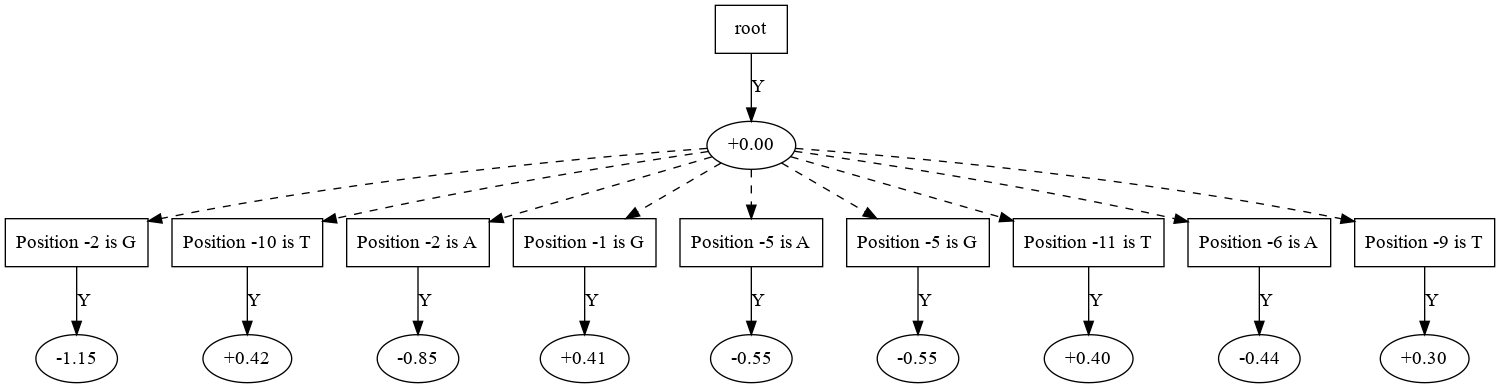

In [20]:
from IPython.display import Image
Image(filename='tree.png')